# Grad-cam_cv

Show the heatmap for multiple images in one folder

Read image method: cv2.imread(file_path)

https://stackoverflow.com/questions/66182884/how-to-implement-grad-cam-on-a-trained-network

In [1]:
from miscellaneous import read_config
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
import os

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Parse configuration file + initializations

In [2]:
# read config files
main_path = os.path.abspath(os.path.dirname(os.getcwd()))
config_path= os.path.join(main_path,'config.yaml')
cfg = read_config(config_path)

# constants
image_height = cfg['image_height']
image_width = cfg['image_width']


# paths
# path_test = cfg['Path']['path_test']


## Grad_cam method

In [3]:
class GradCAM:
    def __init__(self, model, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        # self.classIdx = classIdx
        # self.base_model_name = base_model_name
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model

        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # change image to be a tensor data
        image = image.astype('float32') / 255
        image = np.expand_dims(image, axis=0) 
        
        

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

            # use automatic differentiation to compute the gradients
            grads = tape.gradient(loss, convOutputs)

            # compute the guided gradients
            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            # the convolution and guided gradients have a batch dimension
            # (which we don't need) so let's grab the volume itself and
            # discard the batch
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            # compute the average of the gradient values, and using them
            # as weights, compute the ponderation of the filters with
            # respect to the weights
            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            # grab the spatial dimensions of the input image and resize
            # the output class activation map to match the input image
            # dimensions
            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            # normalize the heatmap such that all values lie in the range
            # [0, 1], scale the resulting values to the range [0, 255],
            # and then convert to an unsigned 8-bit integer
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
            
            # return the resulting heatmap to the calling function
            return heatmap

    def overlay_heatmap(self, heatmap, image, colormap, alpha=0.5,
                        ):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)


## Load model

In [4]:
model_path = r"F:\Tianlong\PythonProject\deep_plastic\output\TL_vs_scratch\model_trained_for_GradCam\weights\mobile_net_lr_0.0001_TL_all_GC.hdf5"
# model_path = r"F:\Tianlong\PythonProject\deep_plastic\output\TL_vs_scratch\from_scratch_weights\squeeze_net_lr_0.00001.hdf5"

model = tf.keras.models.load_model(model_path)


# model.summary()


## Get the layer's name of the model

In [5]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `Conv_1` layer 

input_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

## Load test images

The shape of one image is:  (224, 224, 3)
One image is: 


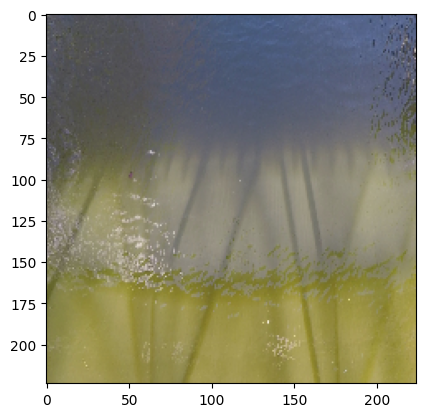

In [6]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder,filename)
        image = cv2.imread(file_path)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        if image is not None:
            images.append(image)
    return images

folder_name=r'F:\Tianlong\Data\Deep_Plastic\Data\Exp1\1\1'
images = load_images_from_folder(folder_name)
print("The shape of one image is: ",images[0].shape)
print("One image is: ")
plt.imshow(images[0])


## Passing to GradCAM class and Visualization

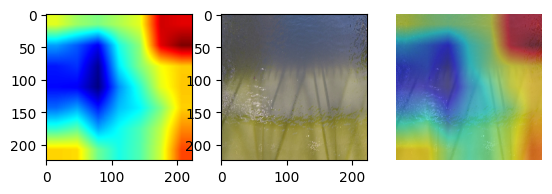

In [7]:
last_conv_layer_name = "Conv_1"
layerName = last_conv_layer_name

icam = GradCAM(model, layerName)

# Choose one colodrmap for heatmap
colormap=cv2.COLORMAP_JET
# colormap=cv2.COLORMAP_VIRIDIS
# colormap = cv2.COLORMAP_PARULA

for image in images:
    heatmap = icam.compute_heatmap(image)
    (heatmap, output) = icam.overlay_heatmap(
        heatmap, image, colormap, alpha=0.5)
    # print(heatmap.shape, image.shape)

    # Visualization
    fig, ax = plt.subplots(1, 3)
    plt.axis('off')
    ax[0].imshow(heatmap)
    ax[1].imshow(image)
    ax[2].imshow(output)



In [8]:
# Predict the class of one image

# display(Image(img_path))
labels = ['No', 'Little', 'Moderate', 'Lot']

image = images[0].astype('float32') / 255
image = np.expand_dims(image, axis=0)
print(image.shape)
preds = model.predict(image) 
i = np.argmax(preds)
print ("predicted class: ", labels[i])

(1, 224, 224, 3)
predicted class:  Little
